## Simulating the spin model:

In [1]:
import statsmodels.api as sm
import pickle

In [7]:
from ising_utils import *

In [8]:
# parameters
parameters = {'J': 1.0, 'alpha': 4.0}
strategies = {'C': np.ones(1024)}
side = 32
dim = 2
T = 1.5

In [9]:
def bornholdt_field(model, i):
    """Compute the local field at spin i"""
    total_neighbors = np.sum(model.connection_matrix[i] * model.spins)
    magnetization = np.sum(model.spins) / len(model.spins)
    return model.params['J'] * total_neighbors - model.params['alpha'] * model.strategy_list[-1]['C'][i] * magnetization

In [10]:
def bornholdt_update_strategy(model):
    current_C = model.strategy_list[-1]['C']
    next_C = np.copy(current_C)
    alpha_mag = model.params['alpha']*np.sum(model.spins)
    for i in range(model.size):
        if model.spins[i]*current_C[i]*alpha_mag < 0:
            next_C[i] = -current_C[i]
    return {'C': next_C}

Running simulation with 1024 spins, J=1.0, alpha=4.0, T=1.5, steps=30000
Step 0/30000
Step 3000/30000
Step 6000/30000
Step 9000/30000
Step 12000/30000
Step 15000/30000
Step 18000/30000
Step 21000/30000
Step 24000/30000
Step 27000/30000
Simulation finished


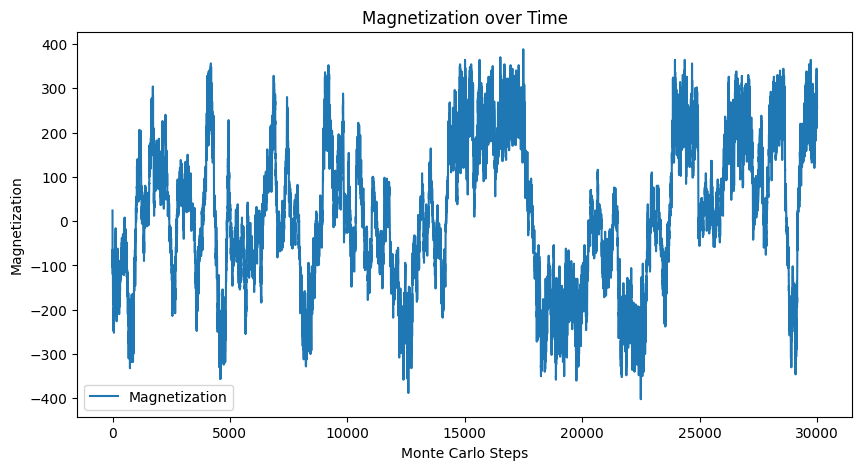

interactive(children=(IntSlider(value=0, description='t', max=29999), Output()), _dom_classes=('widget-interac…

In [13]:
# Running the simulation
model = LatticeSpinMarketModel(side=side, dim=dim, params=parameters, T=T,  local_field_func=bornholdt_field, strategy_update_func=bornholdt_update_strategy, initial_strategy=strategies)
spin_series = model.run_simulation(steps=30000, verbose=True)
model.plot_magnetization()
model.plot_lattice(interactive=True)

In [14]:
pickle.dump(model, open("bornholdt_model.pkl", "wb"))

In [12]:
model = pickle.load(open("bornholdt_model.pkl", "rb"))

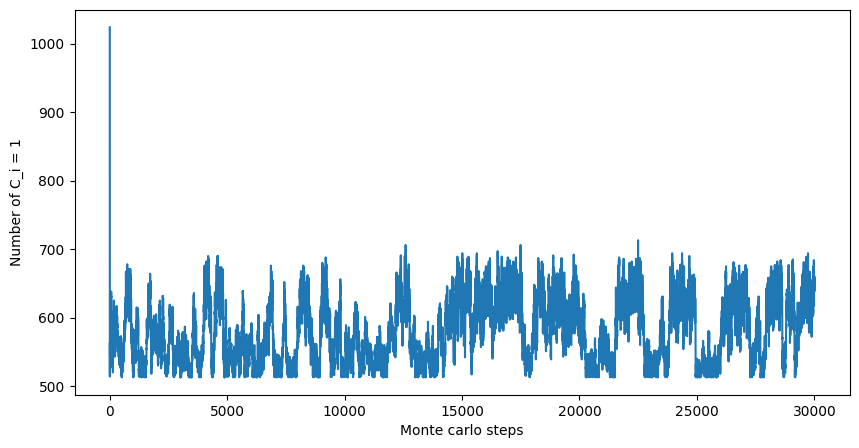

In [15]:
model.strategy_list
ones = [np.count_nonzero(strategy['C'] == 1) for strategy in model.strategy_list]
plt.figure(figsize=(10, 5))
plt.plot(ones, label='ones')
plt.xlabel('Monte carlo steps')
plt.ylabel('Number of C_i = 1')
plt.show()

In the paper, it is not clear how the logarithmic relative change $\text{ret}(t)=\ln(M(t))-\ln(M(t-1))$ is defined, considering that $M(t)$ can have negative values. We test shifting all its values up by its minimum possible value, and using its absolute value.

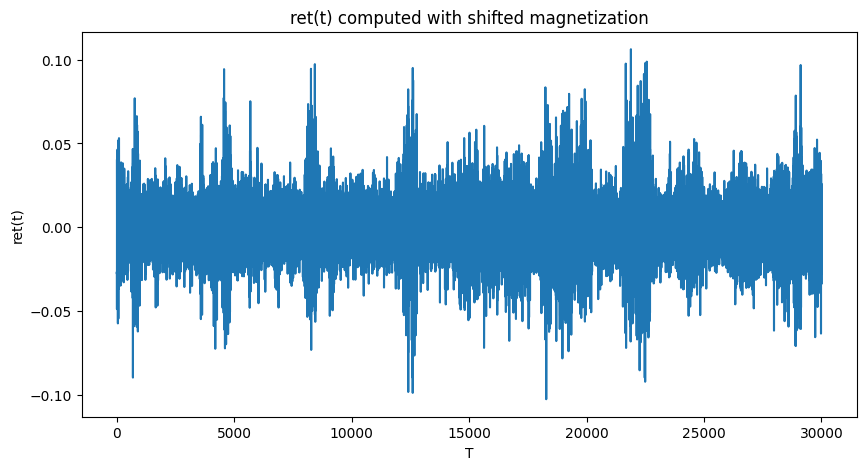

In [16]:
n = side**dim

magnetization_series_shifted = [np.sum(spin)/n + 1 for spin in model.spin_series]

log_returns = np.diff(np.log(magnetization_series_shifted))

plt.figure(figsize=(10, 5))
plt.plot(log_returns)
plt.xlabel("T")
plt.ylabel("ret(t)")
plt.title("ret(t) computed with shifted magnetization")
plt.show()

/var/folders/2n/ywnb5cc17zq6c5n2w2n7bkzw0000gn/T/ipykernel_29815/2064790656.py:3: RuntimeWarning: divide by zero encountered in log
  log_returns = np.diff(np.log(abs_magnetization_series))
/Users/edoardoghirardo/miniconda/envs/thesis/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1496: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


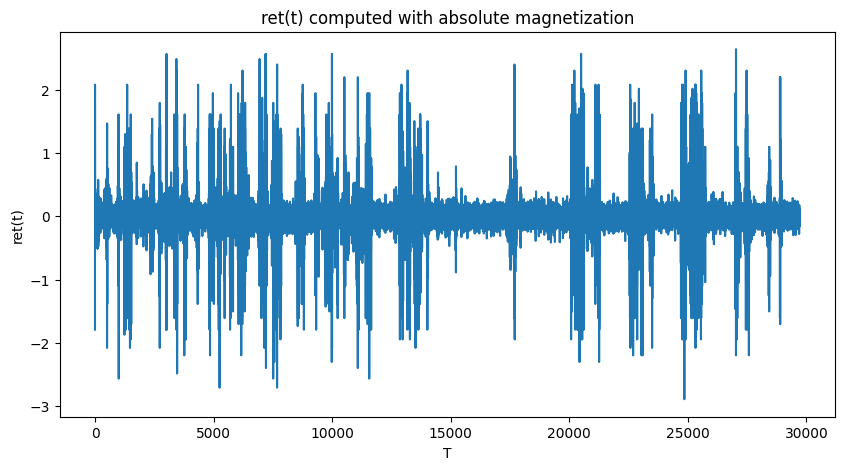

In [17]:
abs_magnetization_series = [abs(np.sum(spin))/n for spin in model.spin_series]

log_returns = np.diff(np.log(abs_magnetization_series))
log_returns = log_returns[np.isfinite(log_returns)]

plt.figure(figsize=(10, 5))
plt.plot(log_returns)
plt.xlabel("T")
plt.ylabel("ret(t)")
plt.title("ret(t) computed with absolute magnetization")
plt.show()

Qualitatively, the graph corresponding to the absolute value resembles the one in the paper more closely. We will use that one for now. Next, we plot the cumulative distribution of log returns.

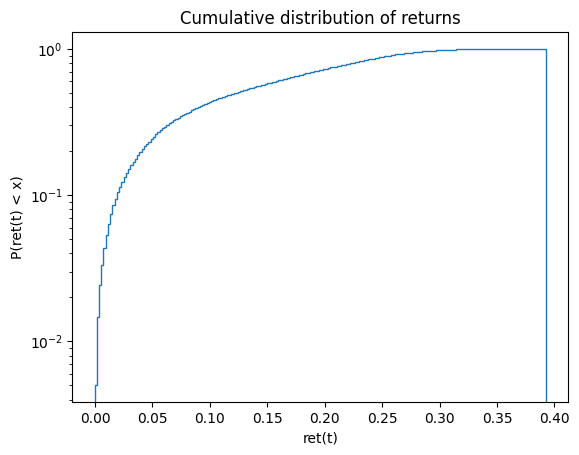

In [18]:
abs_returns = np.abs(np.diff([np.sum(spin) for spin in model.spin_series]))
plt.hist(abs_magnetization_series, bins=500, density=True, cumulative=True, histtype='step')
plt.xlabel("ret(t)")
plt.ylabel("P(ret(t) < x)")
plt.title("Cumulative distribution of returns")
plt.yscale('log')
plt.show()

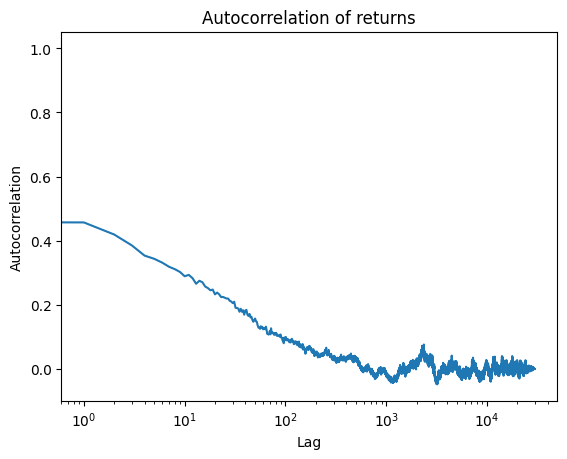

In [23]:
autocorr = sm.tsa.acf(np.abs(log_returns), nlags=np.shape(log_returns)[0] - 1)

plt.plot(autocorr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of returns")
plt.xscale('log')
plt.show()

# understand better

to do:
- understand what kind of magnetization is used
- understand the distribution of returns